# Implementación del modelo de ML


## Instalar librerías

In [1]:

# Para el manejo y carga de datos
import pyarrow.parquet as pq
# Manipulación de datos
import pandas as pd
import numpy as np
import re
#Visualización de datos
import matplotlib.pyplot as plt
# Divisió del dataset
from sklearn.model_selection import train_test_split
# Selección de variables importantes
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

# Implementación de modelos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
# Importar grilla para prueba
from sklearn.model_selection import GridSearchCV
# Medir tiempos
import time
# Métricas de evaluación del modelo
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score




In [2]:
from feature_engine.encoding import MeanEncoder

In [3]:
from feature_engine.selection import RecursiveFeatureElimination


In [4]:
from catboost import CatBoostClassifier

In [5]:
from scipy.stats.mstats import winsorize

In [6]:
# Modelos adicionales
"""
from catboost impoty CatBoostClassifier
from lightgbm import LGBMClassifier
"""


'\nfrom catboost impoty CatBoostClassifier\nfrom lightgbm import LGBMClassifier\n'

## Descargar datos a utilizar 

In [7]:
# Descargar los datos pertinentes
path = "C:/Users/josem/Documents/No country/"
data = "application_data_procesada.parquet"
parquet_table = pq.read_table(path + data)
df = parquet_table.to_pandas()
#df = pd.read_parquet('../DataSets/application_data_procesada.parquet')


In [8]:
# Mostrar las primeras filas
df.head(3)

,ID_CREDITO,OBJETIVO,TIPO_PAGO,GENERO,PROP_AUTO,PROP_INMUEBLE,CANTIDAD_HIJOS,INGRESO,MONTO_CREDITO,ANUALIDAD_PRESTAMO,...,CALIFICACION_REGION_CLIENTE_CIUDAD,DIA_SEMANA_SOLICITUD,HORA_SOLICITUD,DIRECCION_PERMANENTE_NO_DIRECCION_CONTACTO,DIRECCION_PERMANENTE_NO_DIRECCION_TRABAJO,DIRECCION_CONTACTO_NO_DIRECCION_TRABAJO,NO_VIVE_CIUDAD_REGISTRADA,NO_TRABAJA_CIUDAD_REGISTRADA,NO_VIVE_CIUDAD_DE_TRABAJO,TIPO_ORGANIZACION
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,1,MONDAY,11,0,0,0,0,0,0,School
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,2,MONDAY,9,0,0,0,0,0,0,Government


In [9]:
# Vistazo a todos los nombres de las columnas.
df.columns

Index(['ID_CREDITO', 'OBJETIVO', 'TIPO_PAGO', 'GENERO', 'PROP_AUTO',
       'PROP_INMUEBLE', 'CANTIDAD_HIJOS', 'INGRESO', 'MONTO_CREDITO',
       'ANUALIDAD_PRESTAMO', 'PRECIO_BIENES', 'TIPO_ACOMPAÑANTE',
       'TIPO_INGRESO', 'NIVEL_ESTUDIO', 'ESTADO_CIVIL', 'TIPO_VIVIENDA',
       'POBLACION_RELATIVA_REGION', 'EDAD_DIAS', 'DIAS_EMPLEADO',
       'DIAS_MODIF_REGISTRO', 'DIAS_MODIF_DOCUMENTO', 'TIENE_CELULAR',
       'TELEFONO_EMPLEO', 'TELEFONO_TRABAJO', 'ATIENDE_CELULAR',
       'TELEFONO_CASA', 'EMAIL', 'PROFESION', 'CANTIDAD_MIEMBROS_FAMILIA',
       'CALIFICACION_REGION_CLIENTE', 'CALIFICACION_REGION_CLIENTE_CIUDAD',
       'DIA_SEMANA_SOLICITUD', 'HORA_SOLICITUD',
       'DIRECCION_PERMANENTE_NO_DIRECCION_CONTACTO',
       'DIRECCION_PERMANENTE_NO_DIRECCION_TRABAJO',
       'DIRECCION_CONTACTO_NO_DIRECCION_TRABAJO', 'NO_VIVE_CIUDAD_REGISTRADA',
       'NO_TRABAJA_CIUDAD_REGISTRADA', 'NO_VIVE_CIUDAD_DE_TRABAJO',
       'TIPO_ORGANIZACION'],
      dtype='object')

In [10]:
# Algunos modelos funcionan mejor con el tipo snake_case (y me gusta más en minus)
def to_snake_case(col):
    col = col.replace(' ', '_')
    p = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', col)
    return re.sub('([a-z0-9])(A-Z)', r'\1_\2', p).lower()


In [11]:
# Aplicar la función definida previamente
df.columns = [to_snake_case(col) for col in df.columns]

Dado que queremos realizar distintos modelos, lo más recomendable es transformar cada uno de los datos para que todos los modelos puedan procesarlos fácilmente.
- Columnas numéricas: escalarlas con StandardScaler()
- Columnas dicotómicas: aplicar OneHotEncoder()
- Columnas categóricas con demasiadas categorías: es mejor aplicar codificación de etiquetas para no generar un gran número de columnas. 
- Columnas ordinales: aplicar una codificación ordinal.

Es recomendable realizar una lista con aquellas columnas que recibirán el mismo tratamiento para los modelos. Se excluyen las columnas de `ID_CREDITO` Y `OBJETIVO` porque la primera no agregará información al modelo y la segunda es nuestra variable objetivo.

In [12]:
# Columnas numéricas: columnas con valores numéricos y cero absolutos.
numerical_x = ['cantidad_hijos', 'ingreso', 'monto_credito', 'anualidad_prestamo', 'precio_bienes', 'edad_dias', 'dias_empleado', 'dias_modif_registro', 'dias_modif_documento',
                'cantidad_miembros_familia']

# Columnas ordinales: columnas cuyos valores dependen del orden. 
ord_x = ['nivel_estudio', 'calificacion_region_cliente', 'calificacion_region_cliente_ciudad']

# Lista de variables dicotómicas
dichotomic_x = ['genero', 'prop_auto', 'prop_inmueble', 'tiene_celular', 'telefono_empleo', 'telefono_trabajo', 'atiende_celular', 'telefono_casa','email',
                'direccion_permanente_no_direccion_contacto', 'direccion_permanente_no_direccion_trabajo', 'direccion_contacto_no_direccion_trabajo', 'no_vive_ciudad_registrada',
                'no_trabaja_ciudad_registrada', 'no_vive_ciudad_de_trabajo']

# Lista de variables categóricas
categorical_x = ['tipo_pago', 'tipo_acompañante', 'tipo_ingreso', 'estado_civil', 'tipo_vivienda', 'profesion', 'dia_semana_solicitud', 'tipo_organizacion']

# Corroborar que están todas las columnas: deben ser 36
len(numerical_x) + len(ord_x) + len(dichotomic_x) + len(categorical_x)

36

 Creo que no habría que meter la columna de `población_relativa_region` porque esa está escalada y no sé cómo escalarla con respecto a las demás.


Es recomendable obtener las principales medidas de distribución.

In [13]:
df.iloc[:,0:18].describe()

,id_credito,objetivo,cantidad_hijos,ingreso,monto_credito,anualidad_prestamo,precio_bienes,poblacion_relativa_region,edad_dias
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307511.000000,3.075110e+05,307511.000000,307511.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.454517,3.692794e+05,0.013831,4363.988632
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000


In [14]:
# Mostrar describe de demás columnas
df.iloc[:,18:28].describe()

,dias_empleado,dias_modif_registro,dias_modif_documento,tiene_celular,telefono_empleo,telefono_trabajo,atiende_celular,telefono_casa,email
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,63815.045904,-4986.120328,-2994.202373,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720
std,141275.766519,3522.886321,1509.450419,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307
min,-17912.000000,-24672.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-2760.000000,-7479.500000,-4299.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,-1213.000000,-4504.000000,-3254.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,-289.000000,-2010.000000,-1720.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,365243.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
# Mostrar describe de las columnas faltantes.
df.iloc[:,28:35].describe()

,cantidad_miembros_familia,calificacion_region_cliente,calificacion_region_cliente_ciudad,hora_solicitud,direccion_permanente_no_direccion_contacto,direccion_permanente_no_direccion_trabajo
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,2.152651,2.052463,2.031521,12.063419,0.015144,0.050769
std,0.910695,0.509034,0.502737,3.265832,0.122126,0.219526
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,2.000000,10.000000,0.000000,0.000000
50%,2.000000,2.000000,2.000000,12.000000,0.000000,0.000000
75%,3.000000,2.000000,2.000000,14.000000,0.000000,0.000000
max,20.000000,3.000000,3.000000,23.000000,1.000000,1.000000


In [16]:
df.iloc[:,35:40].describe()

,direccion_contacto_no_direccion_trabajo,no_vive_ciudad_registrada,no_trabaja_ciudad_registrada,no_vive_ciudad_de_trabajo
count,307511.000000,307511.000000,307511.000000,307511.000000
mean,0.040659,0.078173,0.230454,0.179555
std,0.197499,0.268444,0.421124,0.383817
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


In [17]:
# Observar la cantidad y calidad de `días_empleado` tienen valores imposibles.
df.query('dias_empleado > 360000').iloc[:,18:19].describe()

,dias_empleado
count,55374.0
mean,365243.0
std,0.0
min,365243.0
25%,365243.0
50%,365243.0
75%,365243.0
max,365243.0


# Observaciones generales
- Tenemos alrededor de 24,826 valores objetivo.
- La cantidad de hijos (y por lo tanto los miembros de la familia) tienen valores atípicos.
- El ingreso también tiene valores atípicos.
- Los montos del crédito y las anualidades parecen estar mejor distribuidos. 
- Se recomienda cambiar los `DIAS_EMPLEADO` Y `EDAD_DIAS` de días a años en valores positivos.
- Se propone la eliminación de las columnas de `tiene_celular` y `atiende_celular` ya que son practicamente el 99% 
- La columna de `dias_empleado` tiene valores imposibles (empleado desde hace 1000 años). Podemos sustituir estos valores por la media o eliminar la columna. 
- La columna de género tiene tres categorías.

Es recomendable observar la distribución de las variables.

## Observar la distribución de los datos mediante histogramas

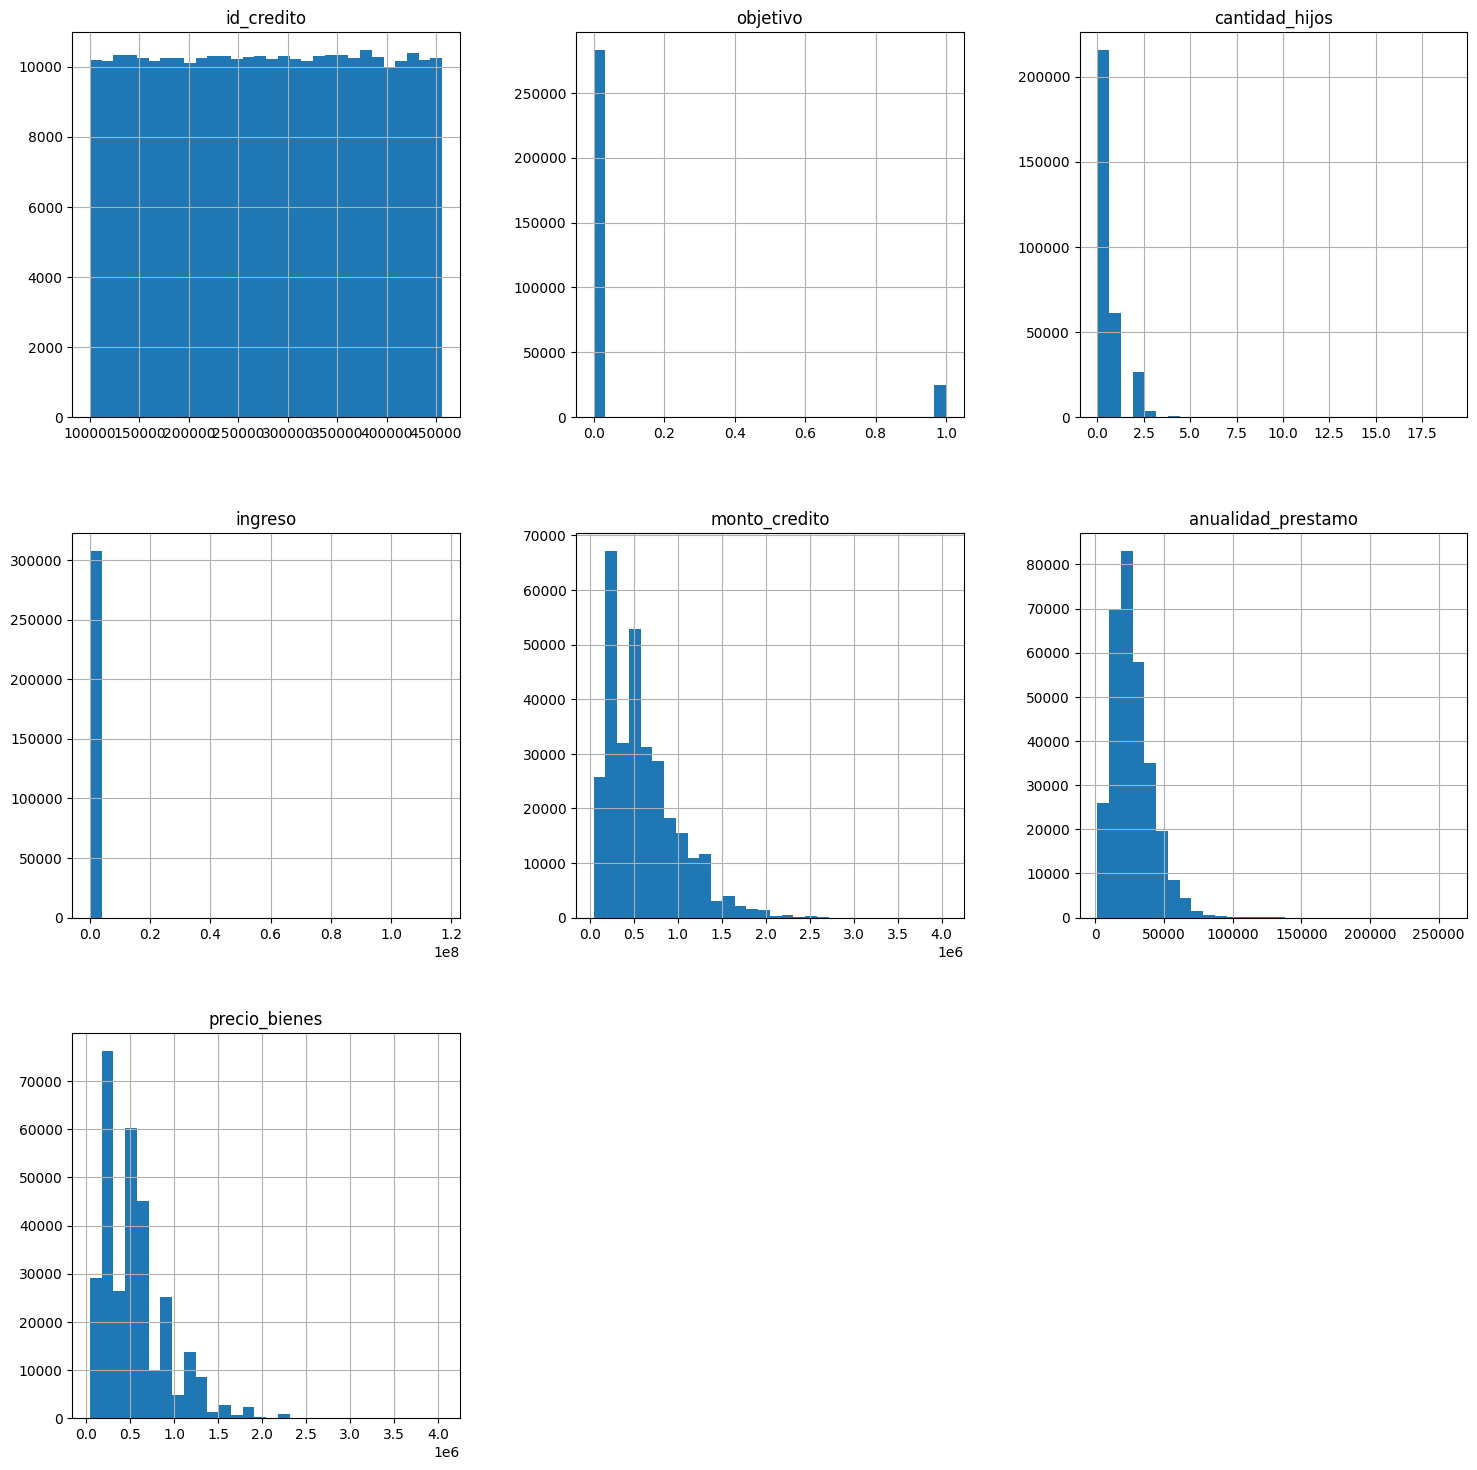

In [18]:
# Observaciones
df.iloc[:,0:15].hist(bins=30, figsize= (18,18))
plt.show()

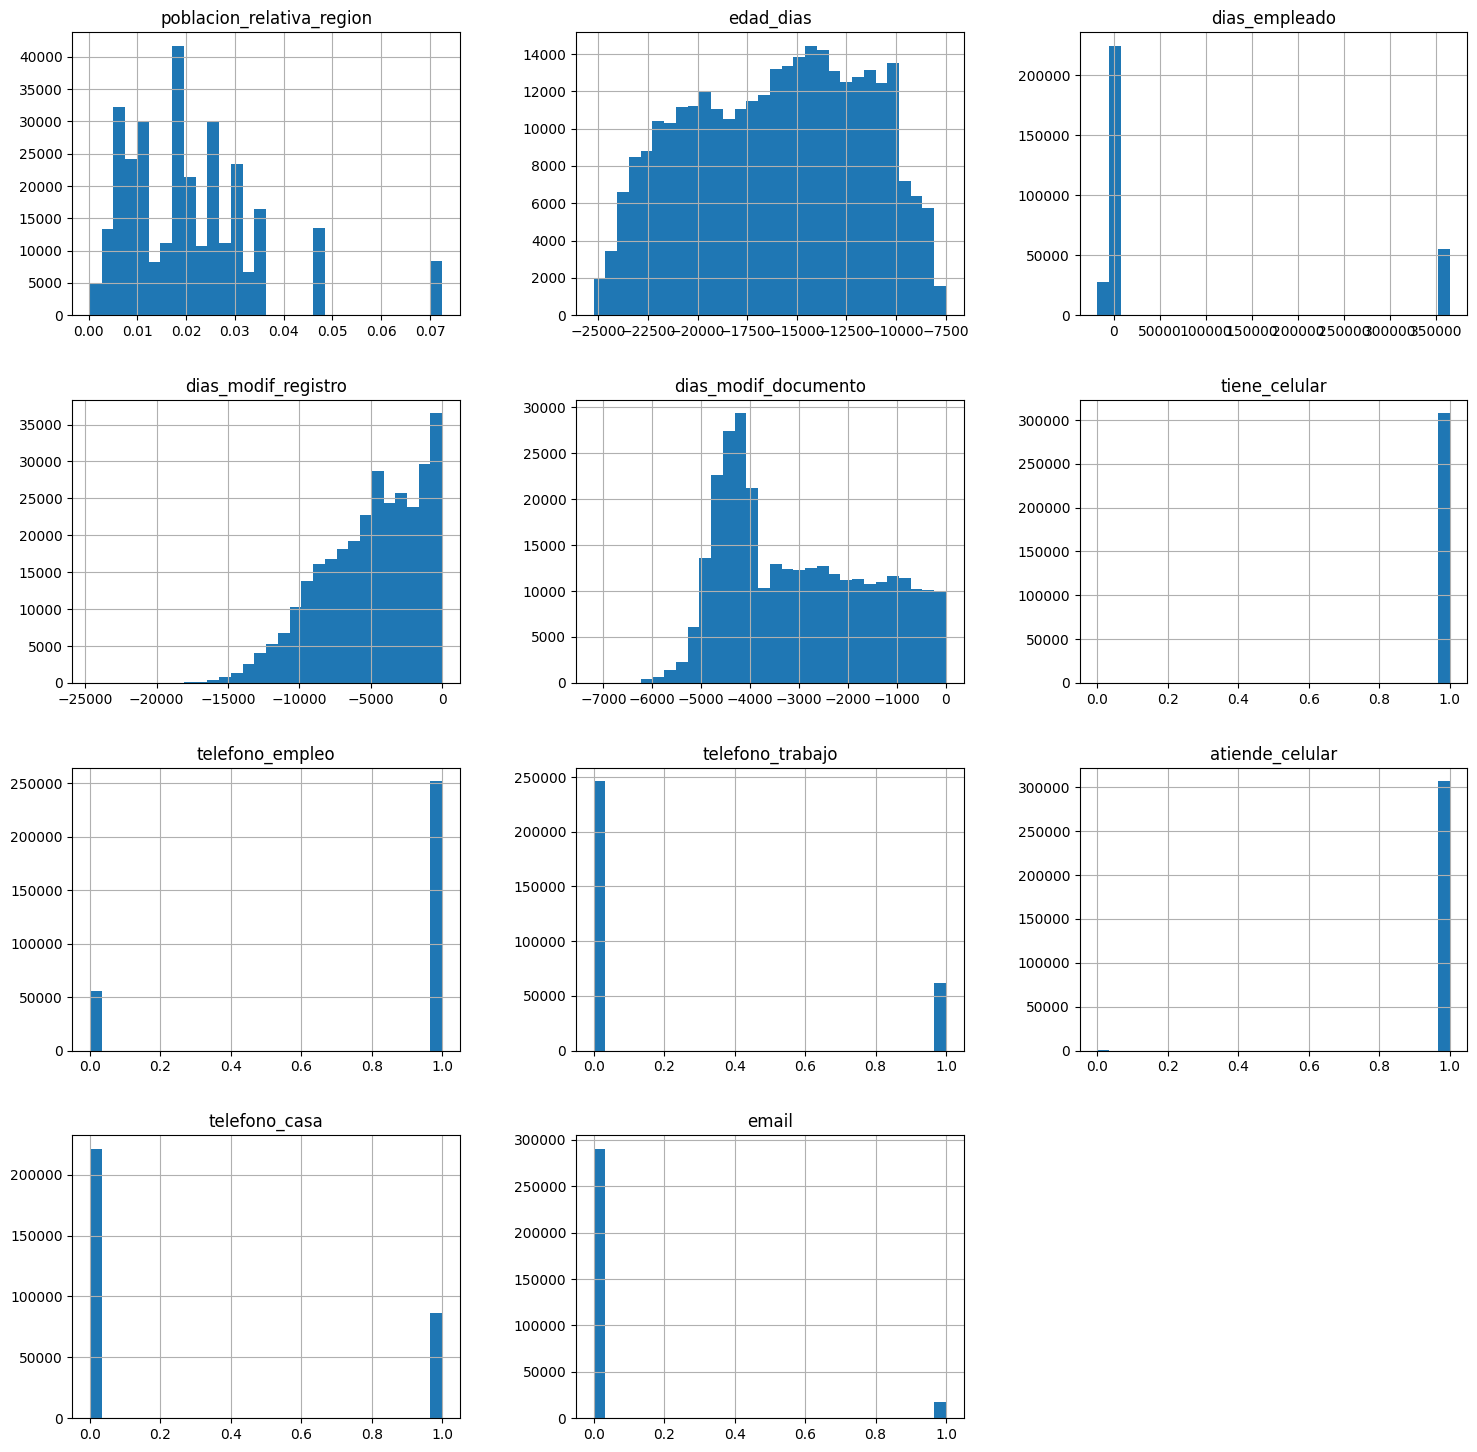

In [19]:
df.iloc[:,15:28].hist(bins=30, figsize= (18,18))
plt.show()

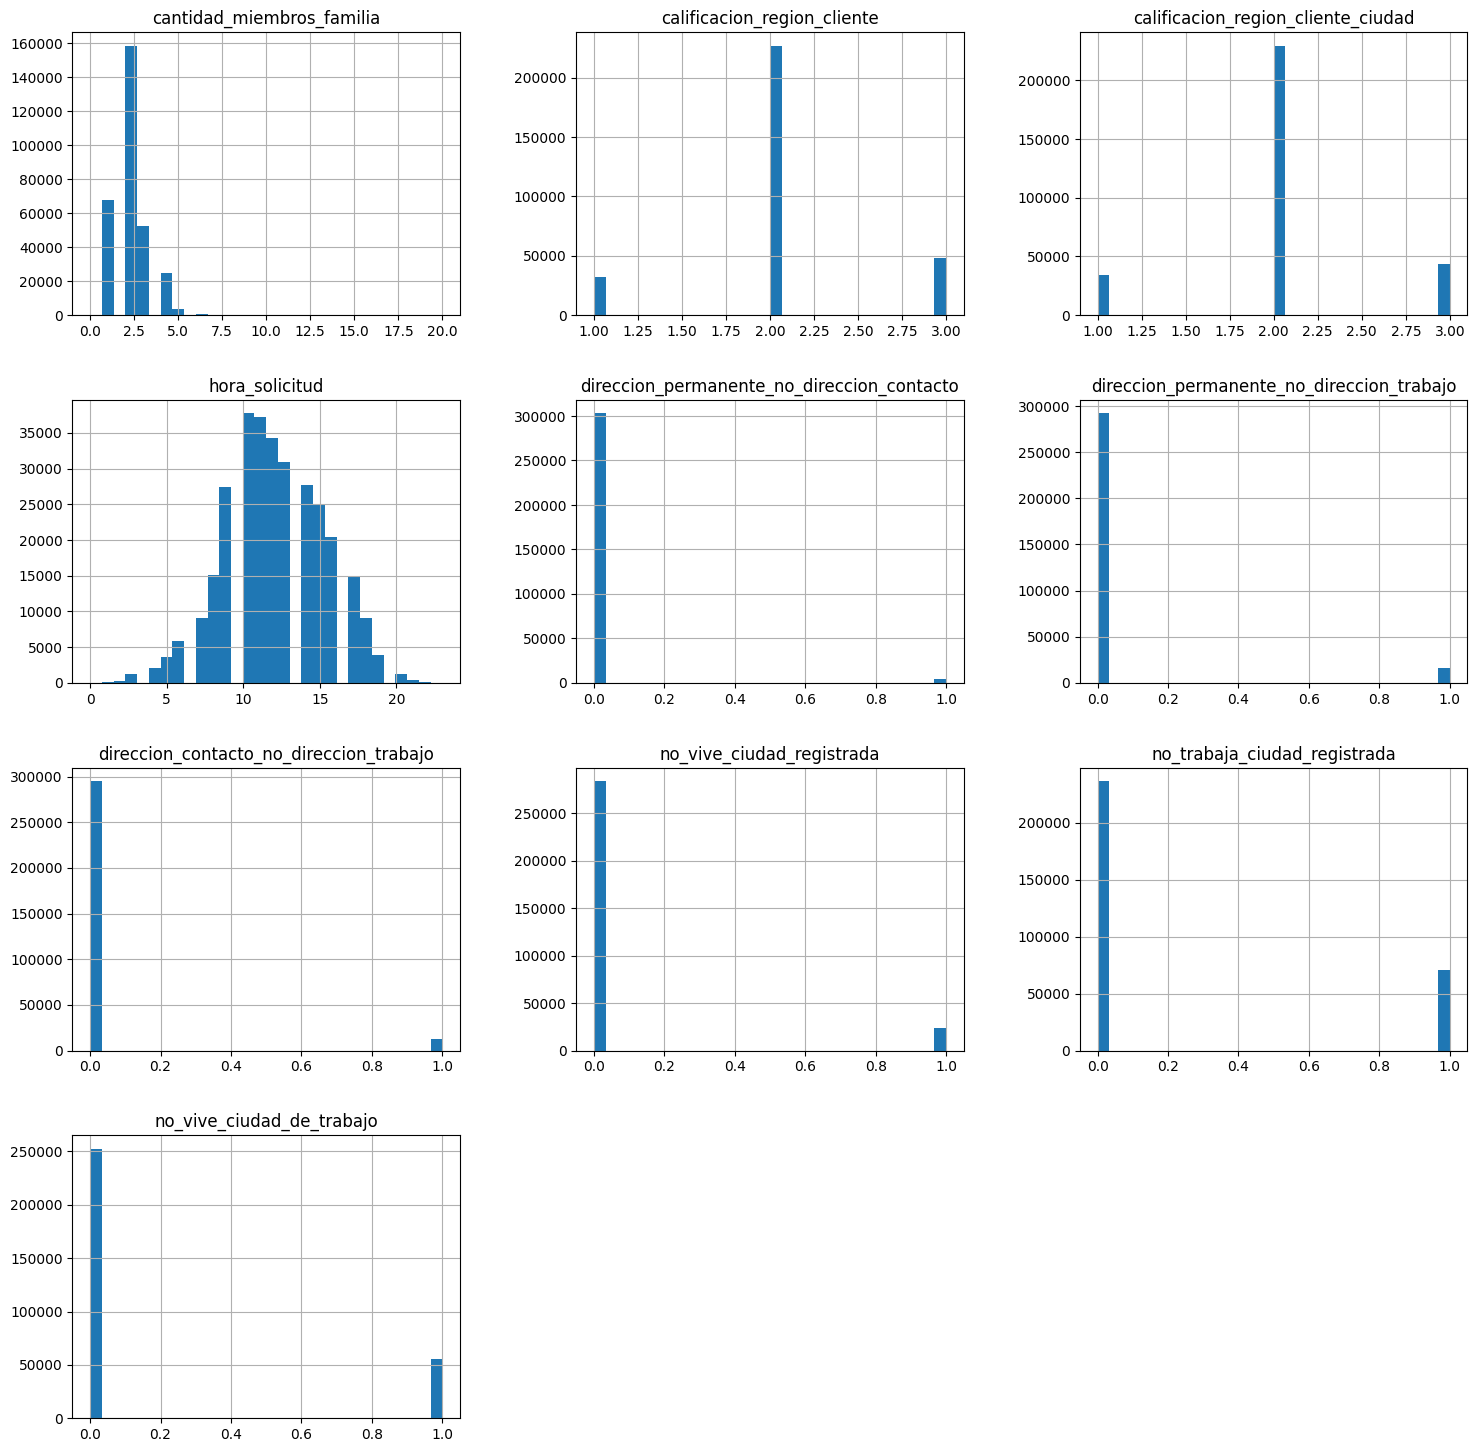

In [20]:
df.iloc[:,28:39].hist(bins=30, figsize= (18,18))
plt.show()

### Observaciones generales
- Casi todas las distribuciones de las variables numéricas tienen valores extremos. Esto es de esperarse ya que son variables relacionadas con el ingreso.
- Las variables dicotómicas conservan un valor de más de 70% en alguna de las dos categorías.



## Correlación lineal entre las variables

Idealmente podríamos observar un gráfico con las relaciones entre pares de variables. No obstante, la gran cantidad de datos hace que sea más viable simplemente calcular  la correlación lineal.

In [21]:
# Podemos observar el grado de correlación lineal entre variables.
(df[numerical_x].corr()).round(3)

,cantidad_hijos,ingreso,monto_credito,anualidad_prestamo,precio_bienes,edad_dias,dias_empleado,dias_modif_registro,dias_modif_documento,cantidad_miembros_familia
cantidad_hijos,1.000,0.013,0.002,0.021,-0.002,0.331,-0.240,0.183,-0.028,0.879
ingreso,0.013,1.000,0.157,0.192,0.160,0.027,-0.064,0.028,0.009,0.016
monto_credito,0.002,0.157,1.000,0.770,0.987,-0.055,-0.067,0.010,-0.007,0.063
anualidad_prestamo,0.021,0.192,0.770,1.000,0.775,0.009,-0.104,0.039,0.011,0.076
precio_bienes,-0.002,0.160,0.987,0.775,1.000,-0.053,-0.065,0.012,-0.009,0.061
edad_dias,0.331,0.027,-0.055,0.009,-0.053,1.000,-0.616,0.332,0.273,0.279
dias_empleado,-0.240,-0.064,-0.067,-0.104,-0.065,-0.616,1.000,-0.210,-0.272,-0.234
dias_modif_registro,0.183,0.028,0.010,0.039,0.012,0.332,-0.210,1.000,0.102,0.173
dias_modif_documento,-0.028,0.009,-0.007,0.011,-0.009,0.273,-0.272,0.102,1.000,-0.021
cantidad_miembros_familia,0.879,0.016,0.063,0.076,0.061,0.279,-0.234,0.173,-0.021,1.000


### Observaciones generales

Las correlaciones lineales relativamente fuertes entre variables son:
- Monto de crédito y precio bienes: .987
- Anualidad y monto del préstamo: .770
- Precio de los bienes y su anualidad: .775

Lo anterior tiene sentido ya que los montos de los préstamos deben estar relacionados directamente con el monto de crédito y su anualidad.

## Ajuste de valores de columnas `dias_empleado`, `edad_dias`, `dias_modif_registro`, `dias_modif_documento`

<Axes: ylabel='Frequency'>

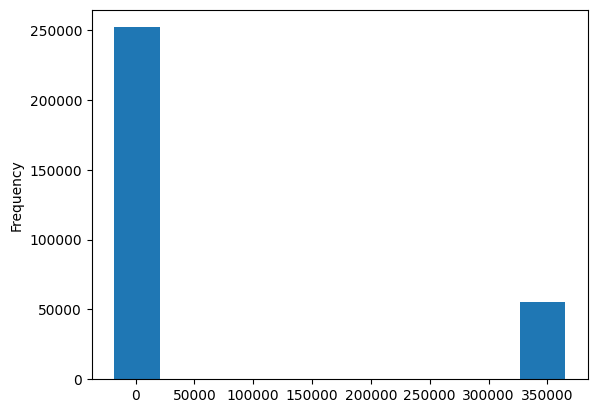

In [22]:
# Dias empleado
df.query('dias_empleado < 3700000')['dias_empleado'].plot(kind='hist')

<Axes: ylabel='Frequency'>

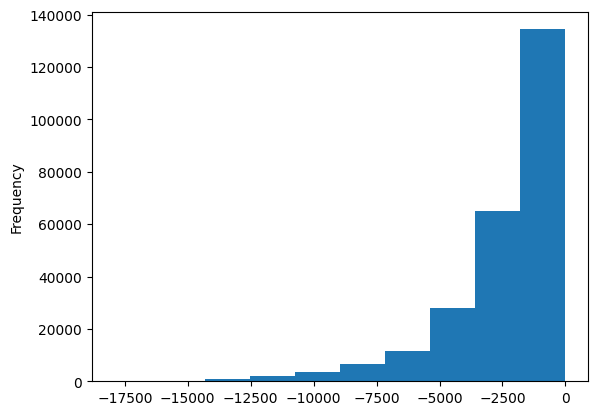

In [23]:
# Distribución de dias empleado sin valores atípicos
df.query('dias_empleado < 0')['dias_empleado'].plot(kind='hist')


### Observaciones generales

Los días empleado mayores a 365000 no son posibles, se recomienda sustituir valores extremos por la moda.

In [24]:
# Dada la distribución de los datos, lo mejor es sustituir los valores exrtremos por la moda de los valores correctos.
mode_dias_empleado = df.query("dias_empleado < 0")['dias_empleado'].mode()
# Sustituir los datos extremos por la moda
df['dias_empleado'] = np.where(df['dias_empleado']>365000, mode_dias_empleado, df['dias_empleado'])
# ELiminar la tercer categoría de genero de 6 columnas.
df['genero'] = np.where(df['genero']=="XNA", 'M', df['genero'])
# Convertir valores a años positivos
df['dias_modif_registro'] = df['dias_modif_registro'] / - 365
# Convertir valores a años positivos
df['dias_modif_documento'] = df['dias_modif_documento'] / -365
# Convertir `dias_empleado` a años positivos
df['dias_empleado'] = df['dias_empleado'] / -365
# Convertir edad en días a años positivos
df['edad_dias'] = df['edad_dias'] / - 365

In [25]:

########################## Redondear años
df[['dias_empleado', 'dias_modif_registro', 'dias_modif_documento', 'edad_dias']].describe()

,dias_empleado,dias_modif_registro,dias_modif_documento,edad_dias
count,307511.000000,307511.000000,307511.000000,307511.000000
mean,5.454418,13.660604,8.203294,43.936973
std,6.240124,9.651743,4.135481,11.956133
min,-0.000000,-0.000000,-0.000000,20.517808
25%,0.791781,5.506849,4.712329,34.008219
50%,3.323288,12.339726,8.915068,43.150685
75%,7.561644,20.491781,11.778082,53.923288
max,49.073973,67.594521,19.717808,69.120548


## Preprocesamiento de datos para implementación en los modelos


### Extraer variable objetivo del conjunto de datos.

In [26]:
# Extraer variable objetivo y dividir conjunto de datos para entrenamiento y prueba
x = df.drop(['objetivo', 'id_credito', 'poblacion_relativa_region', 'hora_solicitud'], axis = 1)
# Variable objetivo
y = df['objetivo']

### Dividir conjunto de entrenamiento del conjunto de prueba

In [27]:
# Conjunto de entrenamiento y prueba.
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.3, random_state=42)
# Confirmar forma de los nuevos data sets
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((215257, 36), (92254, 36), (215257,), (92254,))

In [28]:
# Observar cuántos valores objetivo cayeron en cada dataset
y_train.sum(), y_test.sum()

(17412, 7413)

In [ ]:
### Reducción de fias en el conjunto de entrenamiento


### Tratameinto de columnas numéricas

In [29]:
# Crear una instancia para el escalado de datos numéricos
scaler = StandardScaler()
# Ajustar y transformar el conjunto de entrenamiento
x_train[numerical_x] = scaler.fit_transform(x_train[numerical_x])
# Ajustar y transformar el conjunto de prueba 
x_test[numerical_x] = scaler.transform(x_test[numerical_x])
# Observar las transformaciones realizadas.
x_train.head(3)


,tipo_pago,genero,prop_auto,prop_inmueble,cantidad_hijos,ingreso,monto_credito,anualidad_prestamo,precio_bienes,tipo_acompañante,...,calificacion_region_cliente,calificacion_region_cliente_ciudad,dia_semana_solicitud,direccion_permanente_no_direccion_contacto,direccion_permanente_no_direccion_trabajo,direccion_contacto_no_direccion_trabajo,no_vive_ciudad_registrada,no_trabaja_ciudad_registrada,no_vive_ciudad_de_trabajo,tipo_organizacion
127044,Cash loans,F,N,N,-0.578908,-0.104452,0.265362,2.751246,0.380564,Unaccompanied,...,1,1,WEDNESDAY,0,0,0,0,0,0,Services
281143,Cash loans,F,Y,Y,0.810571,-0.444539,-0.135161,-0.117939,-0.240303,Unaccompanied,...,2,2,MONDAY,0,0,0,0,0,0,Business Entity Type 3
199799,Cash loans,M,Y,Y,0.810571,0.533210,0.850846,0.038550,0.368391,Unaccompanied,...,2,2,THURSDAY,0,0,0,0,0,0,Self-employed


### Tratamiento de columnas dicotómicas


In [30]:
# Crear instancia de OHE
ohe = OneHotEncoder(drop='first', sparse_output=False)

# Crear un dataframe con los valores bianrios del conjunto de entrenamiento
ohe_x = pd.DataFrame(ohe.fit_transform(x_train[dichotomic_x]), columns = dichotomic_x)
# crear un df con los valores binarios del conjunto prueba.
ohe_x_test = pd.DataFrame(ohe.transform(x_test[dichotomic_x]), columns = dichotomic_x)
# Concatenar con el dataframe original y eliminar las columnas repetidas (train)
x_train_ohe = pd.concat([x_train.drop(columns=dichotomic_x).reset_index(drop=True),ohe_x], axis=1)
# Concatenar con el dataframe original y eliminar las columnas repetidas (test)
x_test_ohe = pd.concat([x_test.drop(columns = dichotomic_x).reset_index(drop=True), ohe_x_test], axis=1)
# Observar primeras tres columnas del nuevo df 
x_test_ohe.head(3)


,tipo_pago,cantidad_hijos,ingreso,monto_credito,anualidad_prestamo,precio_bienes,tipo_acompañante,tipo_ingreso,nivel_estudio,estado_civil,...,telefono_trabajo,atiende_celular,telefono_casa,email,direccion_permanente_no_direccion_contacto,direccion_permanente_no_direccion_trabajo,direccion_contacto_no_direccion_trabajo,no_vive_ciudad_registrada,no_trabaja_ciudad_registrada,no_vive_ciudad_de_trabajo
0,Cash loans,2.200051,0.363166,-0.332686,1.757459,-0.325520,Unaccompanied,Commercial associate,Secondary / secondary special,Married,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,Cash loans,-0.578908,0.745764,1.693274,1.503047,1.731864,Unaccompanied,Commercial associate,Higher education,Single / not married,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Cash loans,-0.578908,0.320656,-0.259361,0.825647,-0.118564,Unaccompanied,Working,Secondary / secondary special,Married,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# Verificar dimensiones
x_train_ohe.shape, x_test_ohe.shape

((215257, 36), (92254, 36))

### Aplicar MeanEncoder() a las columnas categóricas

In [32]:
#crear Instancia
mean_encoder= MeanEncoder(variables=categorical_x, missing_values= 'raise', ignore_format=False)
# C# Aplicar fit_transform al conjunto de entre (esta cosa ya te entrega un dataframe)
mean_encoder_x = mean_encoder.fit_transform(x_train_ohe[categorical_x], y_train.reset_index(drop=True))
# Aplicar la misma transfomación al conjunto de entrenamiento
mean_encoder_x_test = mean_encoder.transform(x_test_ohe[categorical_x])
# Agregar las columnas al dataframe original.
x_train_mean_e = pd.concat([x_train_ohe.drop(columns = categorical_x), mean_encoder_x], axis=1)
x_test_mean_e = pd.concat([x_test_ohe.drop(columns = categorical_x), mean_encoder_x_test], axis=1)
x_test_mean_e.head()

c:\Users\josem\AppData\Local\Programs\Python\Python312\Lib\site-packages\feature_engine\encoding\mean_encoding.py:230: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _lambda * y.groupby(X[var]).mean() + (1.0 - _lambda) * y_prior
c:\Users\josem\AppData\Local\Programs\Python\Python312\Lib\site-packages\feature_engine\encoding\mean_encoding.py:230: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _lambda * y.groupby(X[var]).mean() + (1.0 - _lambda) * y_prior
c:\Users\josem\AppData\Local\Programs\Python\Python312\Lib\site-packages\feature_engine\encoding\mean_encoding.py:230: FutureWarning: The default of observed=Fa

,cantidad_hijos,ingreso,monto_credito,anualidad_prestamo,precio_bienes,nivel_estudio,edad_dias,dias_empleado,dias_modif_registro,dias_modif_documento,...,no_trabaja_ciudad_registrada,no_vive_ciudad_de_trabajo,tipo_pago,tipo_acompañante,tipo_ingreso,estado_civil,tipo_vivienda,profesion,dia_semana_solicitud,tipo_organizacion
0,2.200051,0.363166,-0.332686,1.757459,-0.325520,Secondary / secondary special,-0.627292,-0.539218,-1.232840,0.871856,...,1.0,1.0,0.083693,0.081886,0.075908,0.075848,0.078239,0.096536,0.080880,0.09344
1,-0.578908,0.745764,1.693274,1.503047,1.731864,Higher education,-0.287757,-0.372934,-0.956628,1.030244,...,0.0,0.0,0.083693,0.081886,0.075908,0.098987,0.078239,0.062967,0.080880,0.09344
2,-0.578908,0.320656,-0.259361,0.825647,-0.118564,Secondary / secondary special,0.429600,-0.593184,-0.701990,-1.014220,...,0.0,0.0,0.083693,0.081886,0.095650,0.075848,0.078239,0.096536,0.083833,0.10111
3,-0.578908,0.745764,-0.855790,-0.150167,-0.848996,Secondary / secondary special,0.823699,2.189776,1.756381,0.110401,...,0.0,0.0,0.083693,0.081886,0.057671,0.056344,0.078239,0.060459,0.081997,0.09344
4,-0.578908,-0.529560,-0.723168,-0.775196,-0.824648,Secondary / secondary special,0.984410,-0.388729,0.658346,-1.655062,...,0.0,0.0,0.083693,0.081886,0.095650,0.098987,0.078239,0.106587,0.081881,0.09344


### Aplicar OrdinalEncoder() a las columnas ordinales

In [33]:
ordinalb = OrdinalEncoder()

ordinal_x_b = pd.DataFrame(ordinalb.fit_transform(x_train_mean_e[ord_x]), columns = ord_x)
ordinal_x_test_b = pd.DataFrame(ordinalb.transform(x_test_mean_e[ord_x]), columns = ord_x)
# Concatenar los dataframes a donde pertenecen.
x_train_completed = pd.concat([x_train_mean_e.drop(columns = ord_x).reset_index(drop=True), ordinal_x_b], axis=1)
x_test_completed = pd.concat([x_test_mean_e.drop(columns = ord_x).reset_index(drop=True), ordinal_x_test_b], axis=1)
x_test_completed.head()

,cantidad_hijos,ingreso,monto_credito,anualidad_prestamo,precio_bienes,edad_dias,dias_empleado,dias_modif_registro,dias_modif_documento,cantidad_miembros_familia,...,tipo_acompañante,tipo_ingreso,estado_civil,tipo_vivienda,profesion,dia_semana_solicitud,tipo_organizacion,nivel_estudio,calificacion_region_cliente,calificacion_region_cliente_ciudad
0,2.200051,0.363166,-0.332686,1.757459,-0.325520,-0.627292,-0.539218,-1.232840,0.871856,2.033121,...,0.081886,0.075908,0.075848,0.078239,0.096536,0.080880,0.09344,4.0,1.0,1.0
1,-0.578908,0.745764,1.693274,1.503047,1.731864,-0.287757,-0.372934,-0.956628,1.030244,-1.269367,...,0.081886,0.075908,0.098987,0.078239,0.062967,0.080880,0.09344,1.0,2.0,2.0
2,-0.578908,0.320656,-0.259361,0.825647,-0.118564,0.429600,-0.593184,-0.701990,-1.014220,-0.168538,...,0.081886,0.095650,0.075848,0.078239,0.096536,0.083833,0.10111,4.0,1.0,1.0
3,-0.578908,0.745764,-0.855790,-0.150167,-0.848996,0.823699,2.189776,1.756381,0.110401,-1.269367,...,0.081886,0.057671,0.056344,0.078239,0.060459,0.081997,0.09344,4.0,0.0,0.0
4,-0.578908,-0.529560,-0.723168,-0.775196,-0.824648,0.984410,-0.388729,0.658346,-1.655062,-1.269367,...,0.081886,0.095650,0.098987,0.078239,0.106587,0.081881,0.09344,4.0,1.0,1.0


In [54]:
x_train_completed.shape, x_test_completed.shape

((215257, 36), (92254, 36))

In [55]:
"""
# Obtener el índice de todos los valores que son iguales a uno desde y_test
x_train_target = x_train_completed[y_train.reset_index(drop=True) == 1 ]
x_train_no_target = x_train_completed[y_train.reset_index(drop=True) == 0 ]
#Obtener una muestra de x_test_no_target
#x_test_no_target_sample = x_test_no_target.sample()
"""

### Conjuntos de datos para aplicar los modelos

In [36]:
# Aplicar RecursiveFeatureElimination
tr = RecursiveFeatureElimination(estimator=LogisticRegression(penalty='l2'),scoring='roc_auc', threshold=.001)
xt = tr.fit_transform(x_train_completed, y_train.reset_index(drop=True))
xt_columns = list(set(x_train_completed.columns) - set(tr.features_to_drop_))
xt_columns

c:\Users\josem\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\josem\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

['monto_credito',
 'dias_modif_documento',
 'prop_auto',
 'precio_bienes',
 'telefono_trabajo',
 'anualidad_prestamo',
 'profesion',
 'nivel_estudio',
 'tipo_organizacion',
 'calificacion_region_cliente_ciudad',
 'edad_dias',
 'dias_empleado',
 'genero']

In [43]:
# Columnas utilizadas por Mili en el dashboard
mili_set = ['anualidad_prestamo', 'genero', 'prop_auto', 'prop_inmueble', 'monto_credito', 'ingreso', 'tipo_pago', 'edad_dias', 'tipo_ingreso', 'nivel_estudio', 'profesion', 'tipo_vivienda', 'estado_civil', 'cantidad_miembros_familia', 'cantidad_hijos', 'dia_semana_solicitud', 'precio_bienes']

## Implementación del modelo

In [78]:
# Crear una función para hacer distintos modelamientos
def modeling(instance, params, x_train, y_train, x_test, y_test):
    #Eliminate warnings if present
    import warnings
    warnings.filterwarnings("ignore")
    # Grid for to implement
    model_grid = GridSearchCV(instance, params, cv=5, scoring='roc_auc')
    # Training
    start = time.time()
    model_grid.fit(x_train, y_train)
    end = time.time()
    # Results from training
    print('Best AUC-ROC score in training set:', model_grid.best_score_)
    print('')
    print('Best Params:', model_grid.best_params_)
    print('')
    model_omens = model_grid.predict_proba(x_test)[:,1]

    spread = (end-start)

    model_roc = roc_auc_score(y_test, model_omens)
    #recall = recall_score(y_test, model_omens)

    print('AUC-ROC score in test set:', model_roc, '\n' ,'Time for training: {:.3}s'.format(spread))
    #print('recall score in test set:', recall)

    return model_grid.best_score_, model_roc, spread, model_grid

### Modelo de Regresión Logística

In [79]:
log_params = {'penalty':['l1', 'l2', 'elasticnet']}
logistic_model_a = modeling(LogisticRegression(), log_params, x_train_completed, y_train, x_test_completed, y_test)

Best AUC-ROC score in training set: 0.6707910521681677

Best Params: {'penalty': 'l2'}

AUC-ROC score in test set: 0.6691904630426725 
 Time for training: 20.2s


In [81]:
logistic_model_a[3].predict_proba(x_test_completed)

array([[0.86513468, 0.13486532],
       [0.94836072, 0.05163928],
       [0.90855211, 0.09144789],
       ...,
       [0.91131037, 0.08868963],
       [0.96080655, 0.03919345],
       [0.9354378 , 0.0645622 ]])

In [44]:
log_params = {'penalty':['l1', 'l2', 'elasticnet']}
logistic_model_b = modeling(LogisticRegression(), log_params, x_train_completed[mili_set] , y_train, x_test_completed[mili_set], y_test)

Best AUC-ROC score in training set: 0.6472377846399437

Best Params: {'penalty': 'l2'}

AUC-ROC score in test set: 0.6461596957810956 
 Time for training: 6.16s


In [41]:
log_params = {'penalty':['l1', 'l2', 'elasticnet']}
logistic_model_c = modeling(LogisticRegression(), log_params, xt[xt_columns], y_train, x_test_completed[xt_columns], y_test)

Best AUC-ROC score in training set: 0.6687147433068839

Best Params: {'penalty': 'l2'}

AUC-ROC score in test set: 0.6659910835694012 
 Time for training: 6.59s


In [85]:
catb_params = {'depth':[3,4,6],
              'iterations':[170, 180,250],
              'learning_rate':[.24,.25,1],
               'scale_pos_weight': [2,3,4]
              }

cat_model_a = modeling(CatBoostClassifier(verbose=False),  catb_params,x_train_completed[xt_columns], y_train, x_test_completed[xt_columns], y_test)

Best AUC-ROC score in training set: 0.6901536237788928

Best Params: {'depth': 3, 'iterations': 250, 'learning_rate': 0.25, 'scale_pos_weight': 2}

AUC-ROC score in test set: 0.6852768963324676 
 Time for training: 2.96e+03s


In [82]:
catb_params = {'depth':[4,5,6],
              'iterations':[150,200],
              'learning_rate':[.24,.25,.26],
               'scale_pos_weight': [0,3,6]
              }

cat_model_b = modeling(CatBoostClassifier(verbose=False),  catb_params,x_train_completed[mili_set], y_train, x_test_completed[mili_set], y_test)

Best AUC-ROC score in training set: 0.6750855776724277

Best Params: {'depth': 4, 'iterations': 150, 'learning_rate': 0.26, 'scale_pos_weight': 3}

AUC-ROC score in test set: 0.6714334976016976 
 Time for training: 2.33e+03s


In [61]:
x_train.dtypes

tipo_pago                                     category
genero                                          object
prop_auto                                     category
prop_inmueble                                 category
cantidad_hijos                                 float64
ingreso                                        float64
monto_credito                                  float64
anualidad_prestamo                             float64
precio_bienes                                  float64
tipo_acompañante                              category
tipo_ingreso                                  category
nivel_estudio                                 category
estado_civil                                  category
tipo_vivienda                                 category
edad_dias                                      float64
dias_empleado                                  float64
dias_modif_registro                            float64
dias_modif_documento                           float64
tiene_celu

In [70]:
category_col = ['tipo_pago', 'prop_auto', 'prop_inmueble', 'tipo_acompañante', 'tipo_ingreso', 'nivel_estudio', 'estado_civil', 'tipo_vivienda', 'profesion', 'dia_semana_solicitud', 'tipo_organizacion']
x_train[category_col] = x_train[category_col].astype('object')

In [72]:
x_test[category_col] = x_test[category_col].astype('object')

In [ ]:
for column in x_train.columns:
    if column.

In [73]:
catb_params = {'depth':[4,5,12],
              'iterations':[20,50,100,],
              'learning_rate':[.15, .2, .25],
               'scale_pos_weight': [.3,3]
              }

cat_model_d = modeling(CatBoostClassifier(verbose=False),  catb_params, x_train[xt_columns], y_train, x_test[xt_columns], y_test)

ValueError: 
All the 270 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "_catboost.pyx", line 2383, in _catboost.get_float_feature
  File "_catboost.pyx", line 1188, in _catboost._FloatOrNan
  File "_catboost.pyx", line 983, in _catboost._FloatOrNanFromString
TypeError: Cannot convert 'b'N'' to float

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\josem\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\josem\AppData\Local\Programs\Python\Python312\Lib\site-packages\catboost\core.py", line 5220, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "c:\Users\josem\AppData\Local\Programs\Python\Python312\Lib\site-packages\catboost\core.py", line 2385, in _fit
    train_params = self._prepare_train_params(
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\josem\AppData\Local\Programs\Python\Python312\Lib\site-packages\catboost\core.py", line 2265, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_features, embedding_features, pairs,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\josem\AppData\Local\Programs\Python\Python312\Lib\site-packages\catboost\core.py", line 1503, in _build_train_pool
    train_pool = Pool(X, y, cat_features=cat_features, text_features=text_features, embedding_features=embedding_features, pairs=pairs, weight=sample_weight, group_id=group_id,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\josem\AppData\Local\Programs\Python\Python312\Lib\site-packages\catboost\core.py", line 848, in __init__
    self._init(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
  File "c:\Users\josem\AppData\Local\Programs\Python\Python312\Lib\site-packages\catboost\core.py", line 1481, in _init
    self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
  File "_catboost.pyx", line 4159, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4209, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4025, in _catboost._PoolBase._init_features_order_layout_pool
  File "_catboost.pyx", line 2963, in _catboost._set_features_order_data_pd_data_frame
  File "_catboost.pyx", line 2427, in _catboost.create_num_factor_data
  File "_catboost.pyx", line 2385, in _catboost.get_float_feature
_catboost.CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=2]="N": Cannot convert 'b'N'' to float


In [76]:
for i in xt_columns:
    print(x_test[i].value_counts())

monto_credito
-0.371052    2919
 0.187402    2637
-0.929506    2439
-1.041197    2201
-0.817815    2155
             ... 
-0.964085       1
 1.241696       1
 1.773423       1
 0.520330       1
-0.009274       1
Name: count, Length: 4031, dtype: int64
dias_modif_documento
0.764497    57
0.731361    57
0.716782    56
0.857277    55
0.703528    52
            ..
1.568366     1
1.486190     1
2.115103     1
1.589573     1
1.848030     1
Name: count, Length: 5942, dtype: int64
prop_auto
N    61092
Y    31162
Name: count, dtype: int64
precio_bienes
-0.240303    7896
-0.848996    7569
 0.368391    7462
 0.977084    4622
-0.727257    3403
             ... 
-0.756170       1
 1.068424       1
-1.035755       1
 0.162482       1
-0.812389       1
Name: count, Length: 624, dtype: int64
telefono_trabajo
0    73796
1    18458
Name: count, dtype: int64
anualidad_prestamo
-1.247764    1914
-0.937884    1620
-1.402705     703
-1.170294     604
-0.062161     449
             ... 
-1.226383       1
-0.